## Image classification  - Kaggle Plant Seedling Classification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [9]:
PATH = "data/plant-seedlings-classification/"

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## The dataset 
This is provided from kaggle in the plant-seedlings-classfication competition. The .zip files provided are in test and train foldes with the train folder having subfolders for each class (Keras style).

Lets first download the data. Im using the official kaggle CLI https://github.com/Kaggle/kaggle-api

In [ ]:
# !mkdir $PATH
# !kaggle competitions download -c plant-seedlings-classification -p ~/github/fastai/courses/dl1/data/plant-seedlings-classification

Unzip all files provided by Kaggle in to directory and then remove the .zip files

In [ ]:
# !unzip -q '{PATH}*.zip' -d {PATH}

In [ ]:
# !rm -r {PATH}*.zip

In [5]:
os.listdir(PATH)

['train', 'tmp', 'models', 'test', 'labels.csv', 'sample_submission.csv']

Lets create a csv reference file so we can use the much easier `ImageClassifierData.from_csv()` option

In [ ]:
# from glob2 import glob
# import pandas as pd

# df = pd.DataFrame(columns=["file", "species"])

# for image in glob(f'{PATH}train/**/*.png'):
#     dir_ = image.split('/')
#     file_, species = dir_[-1], dir_[-2]

#     df = df.append({
#         "file": file_,
#         "species": species.replace(" ", "_")
#         }, ignore_index=True)

# df.to_csv(f'{PATH}labels.csv', index=False)

Read in our dataframe and view the structure

In [ ]:
# df  = pd.read_csv(f'{PATH}labels.csv')

# df['species'] = df['species'].replace(" ", "_", regex=True)

In [ ]:
# df.to_csv(f'{PATH}labels.csv', index=False)

In [10]:
labels_csv = f'{PATH}labels.csv'
labels_df = pd.read_csv(labels_csv)

# labels_df.head(10)

Now move all the images from under the class subfolders into the root train folder

In [ ]:
# !mv {PATH}train/**/*.png {PATH}train/

Remove all the empty class subfolders from train/

In [ ]:
# !rm -r {PATH}train/**/

Lets view the distribution of the classes a a pivot`

In [8]:
labels_df.pivot_table(index = 'species', aggfunc = len).sort_values('file', ascending = False)

,file
species,
Loose_Silky-bent,654
Common_Chickweed,611
Scentless_Mayweed,516
Small-flowered_Cranesbill,496
Fat_Hen,475
Charlock,390
Sugar_beet,385
Cleavers,287
Black-grass,263


Take a look at the dataset distribution size of images. we first need to define the data loader and transformations. We can later change these or wrap in a data function before training begins


### Initial Model parameters

In [11]:
arch=resnext50 # model architecture to use
sz=224 # image size
bs=32 # mini-batch size

### Make validation indexes

In [12]:
# Create validation indexes
n = len(list(open(labels_csv)))-1
val_idxs = get_cv_idxs(n)

### Transformations

In [13]:
# Data Augementation/Transformation Settings
tfms = tfms_from_model(arch, # pass in architecture
                       sz, # image size
                       aug_tfms=transforms_top_down, # side_on for normal images top_down for satelite of photos taken from above
                       max_zoom=1.15)

### Data Generator

In [14]:
data = ImageClassifierData.from_csv(path = PATH,
                                    folder='train',
                                    csv_fname = labels_csv, # name of the labels reference file
                                    val_idxs = val_idxs, # validation indexes
                                    test_name = 'test',
                                    tfms = tfms, # transformations to apply
                                    bs = bs) #mini batch size

### Data set image resolutions

(array([2604.,  897.,  215.,   59.,   13.,    4.,    3.,    3.,    0.,    2.]),
 array([  49. ,  443.2,  837.4, 1231.6, 1625.8, 2020. , 2414.2, 2808.4, 3202.6, 3596.8, 3991. ]),
 <a list of 10 Patch objects>)

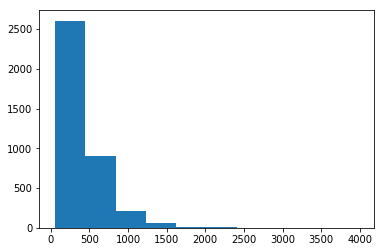

In [19]:
# see distribution of all images
size_d = {k: Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
plt.hist(row_sz)

(array([1008.,  832.,  269.,  431.,  371.,  261.,  193.,  109.,   80.,   64.]),
 array([ 49., 144., 239., 334., 429., 524., 619., 714., 809., 904., 999.]),
 <a list of 10 Patch objects>)

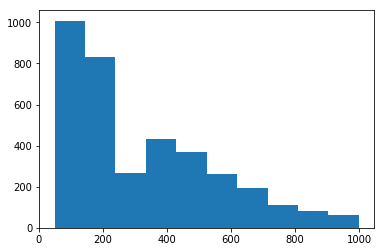

In [18]:
# see distribution of images less than 1000 pixels
plt.hist(row_sz[row_sz < 1000])

## Model Build

In [20]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [ ]:
# shutil.rmtree(f'{PATH}model', ignore_errors=True)

In [16]:
# Create Learner
learn = ConvLearner.pretrained(arch,
                               data,
                               precompute=True)

### Find initial learning rate

In [14]:
# use learn.lr_find to find the optimal learning rate
lrf = learn.lr_find()

 78%|███████▊  | 47/60 [00:01<00:00, 40.14it/s, loss=26.3]


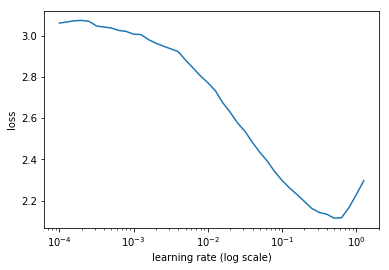

In [15]:
#plot learing rate
learn.sched.plot()

In [16]:
lr = 1e-1

In [17]:
#Fit learner with a few epochs
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.471899   0.824452   0.747368  
    1      0.975393   0.532872   0.821053                  
    2      0.683023   0.439332   0.847368                  



[array([0.43933]), 0.8473684205506977]

In [18]:
learn.precompute=False

In [19]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.633013   0.379534   0.871579  
    1      0.586553   0.359982   0.878947                  
    2      0.54863    0.353986   0.877895                  



[array([0.35399]), 0.8778947384733903]

In [20]:
learn.save('224_lastlayer_resnext50') # training and validation sets

In [25]:
learn.load('224_lastlayer_resnext50') # training and validation sets

In [26]:
learn.unfreeze()
learn.bn_freeze(True)

In [21]:
lrf = learn.lr_find()

 34%|███▎      | 40/119 [00:45<01:30,  1.14s/it, loss=2.15] 

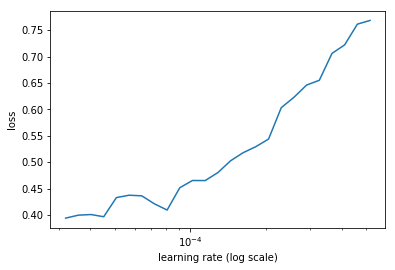

In [22]:
#plot learing rate
learn.sched.plot()

In [27]:
lrs=np.array([1e-6,1e-4,1e-3])

In [28]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name="plantseed_resnext")

epoch      trn_loss   val_loss   accuracy                      
    0      0.338084   0.25202    0.910526  
    1      0.337858   0.221417   0.92                        
    2      0.205734   0.19404    0.929474                    
    3      0.222315   0.192694   0.929474                    
    4      0.187601   0.185757   0.934737                    
    5      0.157373   0.162369   0.942105                    
    6      0.130476   0.153369   0.947368                    



[array([0.15337]), 0.9473684206761812]

In [36]:
learn.save('224_all_lr432_1')

In [37]:
learn.load('224_all_lr432_1')

In [29]:
learn.fit(lrs, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.149768   0.143184   0.949474  
    1      0.144236   0.154117   0.943158                    



[array([0.15412]), 0.9431578943603918]

In [38]:
log_preds,y = learn.TTA(True)
probs = np.mean(np.exp(log_preds),0)

In [39]:
# validation accuracy after TTA
accuracy_np(probs, y)

0.9610526315789474

In [40]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 33   0   0   0   0   0  12   0   1   0   0   0]
 [  0  89   0   0   1   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0]
 [  1   0   0   0  39   1   0   1   0   0   0   0]
 [  0   0   0   0   0  93   0   0   0   0   0   0]
 [ 15   0   0   0   0   0 116   0   0   0   0   0]
 [  0   0   0   0   0   0   0  53   0   0   0   0]
 [  0   0   0   0   0   0   0   0  93   0   0   0]
 [  0   0   0   0   0   0   0   0   3  45   0   0]
 [  0   0   0   0   0   0   1   0   0   0 102   0]
 [  0   0   0   1   0   0   0   0   0   0   0  82]]


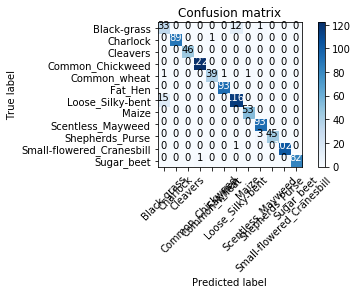

In [42]:
plot_confusion_matrix(cm, data.classes)

## Analyzing results

### Confusion matrix 

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

## Predict the test set

In [82]:
log_preds, y = learn.TTA(is_test=True)

In [83]:
preds = np.mean(np.exp(log_preds),0)

In [85]:
preds.shape

(794, 12)

In [86]:
preds = np.argmax(preds, axis=1)

In [87]:
preds.shape

(794,)

In [88]:
preds_classes = [data.classes[i].replace("_", " ") for i in preds]



In [100]:
submission = pd.DataFrame(preds_classes, os.listdir(f'{PATH}test'))

In [109]:
submission.to_csv(f'{PATH}tmp/subm.csv')

In [110]:
from IPython.display import FileLink
FileLink(f'{PATH}tmp/subm.csv')

/home/ubuntu/github/fastai/courses/dl1/data/plant-seedlings-classification/tmp/subm.csv

In [56]:
ds.shape

(950, 1)

In [53]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

ValueError: Length mismatch: Expected axis has 1 elements, new values have 12 elements

## Prepare submission

First we need to have a look at the sample submission file to see what layout the file needs to be in

In [51]:
samp_sub_df = pd.read_csv(f'{PATH}sample_submission.csv')

From above we can see that we need a filename andthe predicted class `species`

In [52]:
samp_sub_df.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
